In [1]:
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d, spinless_fermion_basis_1d, spin_basis_general # Hilbert space spin basis
from quspin.tools.measurements import obs_vs_time
import numpy as np # generic math functions
import matplotlib.pyplot as plt # plotting library
from matplotlib.colors import LogNorm

In [2]:
from quspin.operators import hamiltonian,exp_op,quantum_operator # operators
from quspin.basis import spinful_fermion_basis_1d # Hilbert space basis
from quspin.tools.measurements import obs_vs_time # calculating dynamics

# test quspin

Hermiticity check passed!
Hermiticity check passed!


C:\Users\alecj\AppData\Local\Temp\ipykernel_3148\1055166259.py:19: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  H_spin=hamiltonian(static_spin,dynamic_spin,basis=basis_spin,dtype=np.float64)


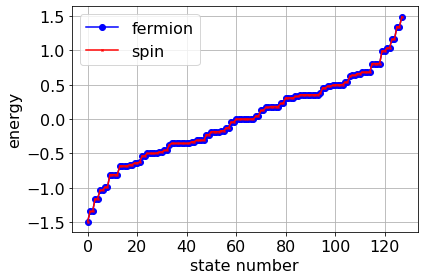

Hermiticity check passed!
Hermiticity check passed!


C:\Users\alecj\AppData\Local\Temp\ipykernel_3148\1055166259.py:19: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  H_spin=hamiltonian(static_spin,dynamic_spin,basis=basis_spin,dtype=np.float64)


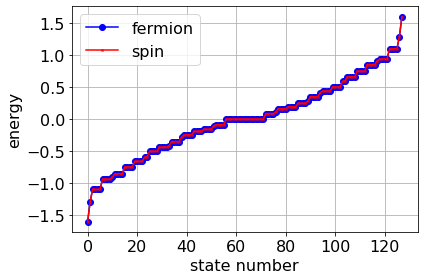

In [5]:
##### define model parameters #####
L=8 # system size
J=1.0 # spin zz interaction
h=np.sqrt(2) # z magnetic field strength
#
# loop over spin inversion symmetry block variable and boundary conditions
for zblock,PBC in zip([-1,1],[1,-1]):
    #
    ##### define spin model
    # site-coupling lists (PBC for both spin inversion sectors)
    h_field=[[-h,i] for i in range(L)]
    J_zz=[[-J,i,(i+1)%L] for i in range(L)] # PBC
    # define spin static and dynamic lists
    static_spin =[["zz",J_zz],["x",h_field]] # static part of H
    dynamic_spin=[] # time-dependent part of H
    # construct spin basis in pos/neg spin inversion sector depending on APBC/PBC
    basis_spin = spin_basis_1d(L=L,zblock=zblock) 
    # build spin Hamiltonians
    H_spin=hamiltonian(static_spin,dynamic_spin,basis=basis_spin,dtype=np.float64)
    # calculate spin energy levels
    E_spin=H_spin.eigvalsh()
    #
    ##### define fermion model
    # define site-coupling lists for external field
    h_pot=[[2.0*h,i] for i in range(L)]
    if PBC==1: # periodic BC: odd particle number subspace only
        # define site-coupling lists (including boudary couplings)
        J_pm=[[-J,i,(i+1)%L] for i in range(L)] # PBC
        J_mp=[[+J,i,(i+1)%L] for i in range(L)] # PBC
        J_pp=[[-J,i,(i+1)%L] for i in range(L)] # PBC
        J_mm=[[+J,i,(i+1)%L] for i in range(L)] # PBC
        # construct fermion basis in the odd particle number subsector
        basis_fermion = spinless_fermion_basis_1d(L=L,Nf=range(1,L+1,2))
    elif PBC==-1: # anti-periodic BC: even particle number subspace only
        # define bulk site coupling lists
        J_pm=[[-J,i,i+1] for i in range(L-1)]
        J_mp=[[+J,i,i+1] for i in range(L-1)]
        J_pp=[[-J,i,i+1] for i in range(L-1)]
        J_mm=[[+J,i,i+1] for i in range(L-1)]
        # add boundary coupling between sites (L-1,0)
        J_pm.append([+J,L-1,0]) # APBC
        J_mp.append([-J,L-1,0]) # APBC
        J_pp.append([+J,L-1,0]) # APBC
        J_mm.append([-J,L-1,0]) # APBC
        # construct fermion basis in the even particle number subsector
        basis_fermion = spinless_fermion_basis_1d(L=L,Nf=range(0,L+1,2))
    # define fermionic static and dynamic lists
    static_fermion =[["+-",J_pm],["-+",J_mp],["++",J_pp],["--",J_mm],['z',h_pot]]
    dynamic_fermion=[]
    # build fermionic Hamiltonian
    H_fermion=hamiltonian(static_fermion,dynamic_fermion,basis=basis_fermion,
                            dtype=np.float64,check_pcon=False,check_symm=False)
    # calculate fermionic energy levels
    E_fermion=H_fermion.eigvalsh()
    #
    ##### plot spectra
    plt.plot(np.arange(H_fermion.Ns),E_fermion/L,marker='o'
                                    ,color='b',label='fermion')
    plt.plot(np.arange(H_spin.Ns),E_spin/L,marker='x'
                                    ,color='r',markersize=2,label='spin')
    plt.xlabel('state number',fontsize=16)
    plt.ylabel('energy',fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)
    plt.grid()
    plt.tight_layout()
    plt.savefig('example4.pdf', bbox_inches='tight')
    plt.show()
    # plt.close()

# rydberg H

In [3]:
def getRydbergEV(L, omega, V0, d):
    Deltas = [[-d/2,i] for i in range(L)]
    Omegas = [[omega/2,i] for i in range(L)]
    V1 = [[V0/4,i,i+1] for i in range(L-1)]
    V2 = [[V0/(4*(2**6)),i,i+2] for i in range(L-2)]
    V3 = [[V0/(4*(3**6)),i,i+3] for i in range(L-3)]


    static_spin =[["zz",V1],["zI",V1],["Iz",V1],["II",V1],
                  ["zz",V2],["zI",V2],["Iz",V2],["II",V2],
                  ["zz",V3],["zI",V3],["Iz",V3],["II",V3],
               ["x",Omegas],
              ["z",Deltas],["I",Deltas]] # static part of H

    dynamic_spin=[] # time-dependent part of H

    basis_spin = spin_basis_1d(L=L,pauli=-1)

    H_spin=hamiltonian(static_spin,dynamic_spin,basis=basis_spin,dtype=np.float64)
    # calculate spin energy levels
    H, V = H_spin.eigh()
    return H, V, basis_spin

In [4]:
def getZ(L, E, V, kT, basis_spin):
    zm = np.zeros(L)
    E -= E.min()
    Z = 0.0
    for E_n in E:
        Z += np.exp(-E_n / kT)
    for i in range(L):
        uu_coeff = [[1.0, i]]
        uu_op = hamiltonian([['z', uu_coeff]],[], basis=basis_spin, check_herm=False, check_symm=False)
        s_avg = 0.
        for E_n, n in zip(E, V.T):
            s_avg += np.real(uu_op.expt_value(n) * np.exp(-E_n / kT))
        zm[i] = s_avg/Z 
    return zm

In [5]:
def getCorr(L, E, V, kT, basis_spin):
    corrij = np.zeros((L,L))
    E -= E.min()
    Z = 0.0
    for E_n in E:
        Z += np.exp(-E_n / kT)
    for i in range(L):
        for j in range(L):
            uu_coeff = [[1.0, i, j]]
            uu_op = hamiltonian([['zz', uu_coeff]],[], basis=basis_spin, check_herm=False, check_symm=False)
            ss_avg = 0.
            for E_n, n in zip(E, V.T):
                ss_avg += np.real(uu_op.expt_value(n) * np.exp(-E_n / kT))
            corrij[i,j] = ss_avg/Z 
    return corrij

Hermiticity check passed!


C:\Users\klab\AppData\Local\Temp\ipykernel_42276\90649507.py:19: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  H_spin=hamiltonian(static_spin,dynamic_spin,basis=basis_spin,dtype=np.float64)


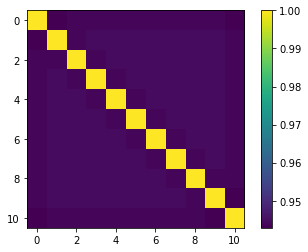

In [60]:
L = 11 # system size
omega = 2
V0 = 24
d = -8
kT = 1e-5
E, V, basis_spin = getRydbergEV(L, omega, V0, d)
zm = getZ(L, E, V, kT, basis_spin)
corrij = getCorr(L, E, V, kT, basis_spin)
plt.imshow(corrij)
plt.colorbar()

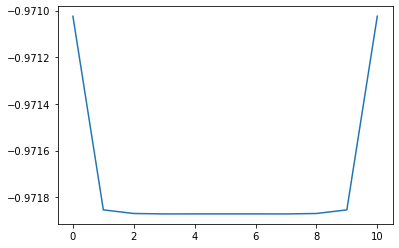

In [61]:
plt.plot(zm)

Hermiticity check passed!


C:\Users\klab\AppData\Local\Temp\ipykernel_37872\90649507.py:19: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  H_spin=hamiltonian(static_spin,dynamic_spin,basis=basis_spin,dtype=np.float64)


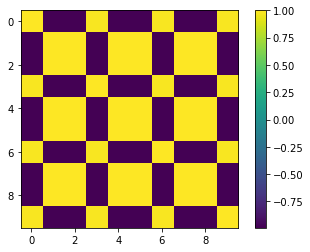

In [117]:
L = 10 # system size
omega = 1.5
V0 = 414
d = 12.0
E, V, basis_spin = getRydbergEV(L, omega, V0, d)
corrij = getCorr(L, E, V, 1e-5, basis_spin)
plt.imshow(corrij)
plt.colorbar()

Hermiticity check passed!


C:\Users\klab\AppData\Local\Temp\ipykernel_37872\90649507.py:19: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  H_spin=hamiltonian(static_spin,dynamic_spin,basis=basis_spin,dtype=np.float64)


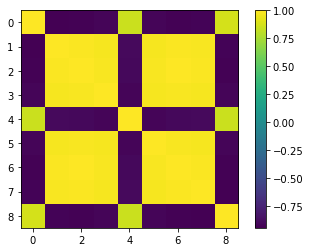

In [40]:
L = 9 # system size
omega = 60*36/(2*560)
V0 = 1536
d = 6
E, V, basis_spin = getRydbergEV(L, omega, V0, d)
corrij = getCorr(L, E, V, 1e-5, basis_spin)
plt.imshow(corrij)
plt.colorbar()

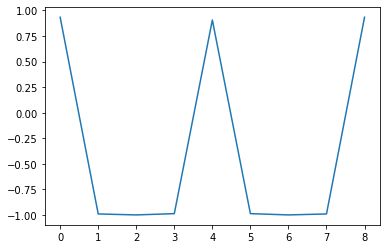

In [41]:
zm = getZ(L, E, V, kT, basis_spin)
plt.plot(zm)

# dynamics

In [58]:
L = 11 # system size
omega = 2
V0 = 0.5
d = 3.0
Deltas = [[-d/2,i] for i in range(L)]
Omegas = [[omega/2,i] for i in range(L)]
V1 = [[V0/4,i,i+1] for i in range(L-1)]
V2 = [[V0/(4*(2**6)),i,i+2] for i in range(L-2)]
V3 = [[V0/(4*(3**6)),i,i+3] for i in range(L-3)]


static_spin =[["zz",V1],["zI",V1],["Iz",V1],["II",V1],
              ["zz",V2],["zI",V2],["Iz",V2],["II",V2],
              ["zz",V3],["zI",V3],["Iz",V3],["II",V3],
           ["x",Omegas],
          ["z",Deltas],["I",Deltas]] # static part of H

dynamic_spin=[] # time-dependent part of H

basis_spin = spin_basis_1d(L=L,pblock=-1,pauli=-1)

H_spin=hamiltonian(static_spin,dynamic_spin,basis=basis_spin,dtype=np.float64,check_symm=False)
# calculate spin energy levels
H, V = H_spin.eigh()

Hermiticity check passed!


In [59]:
# range in time to evolve system
start,stop,num=0.0,50.0,201
t = np.linspace(start,stop,num=num,endpoint=True)
obs_ts = []
for i in range(L):
    print(i)
    Sz_coeff = [[1.0, i]]
    Sz_op = hamiltonian([['z', Sz_coeff]],[], basis=basis_spin, check_herm=False, check_symm=False)

    psi_0 = np.zeros(basis_spin.Ns) # allocate space for state
    psi_0[0] = 1.0 # set MB state to be the given product state

    U = exp_op(H_spin, a=-1j, start=t.min(), stop=t.max(), num=len(t), iterate=True)

    psi_t = U.dot(psi_0)

    t = U.grid # extract time grid stored in U, and defined in exp_op
    obs_t = obs_vs_time(psi_t,t,dict(I=Sz_op))["I"]
    obs_ts.append(obs_t)
obs_ts = np.array(obs_ts)

0
1
2
3
4
5
6
7
8
9
10


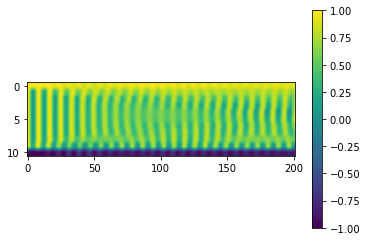

In [60]:
plt.imshow(np.real(obs_ts), aspect=5)
plt.colorbar()

In [14]:
obs_tstot = np.concatenate((np.flipud(obs_ts),obs_ts))

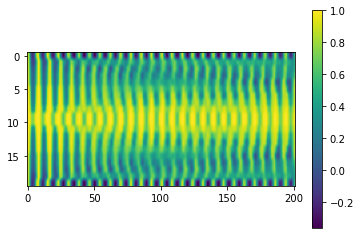

In [15]:
plt.imshow(np.real(obs_tstot), aspect=5)
plt.colorbar()

In [16]:
L = 10 # system size
omega = 2
V0 = 0.5
d = 3.0
Deltas = [[-d/2,i] for i in range(L)]
Omegas = [[omega/2,i] for i in range(L)]
V1 = [[V0/4,i,i+1] for i in range(L-1)]
V2 = [[V0/(4*(2**6)),i,i+2] for i in range(L-2)]
V3 = [[V0/(4*(3**6)),i,i+3] for i in range(L-3)]


static_spin =[["zz",V1],["zI",V1],["Iz",V1],["II",V1],
              ["zz",V2],["zI",V2],["Iz",V2],["II",V2],
              ["zz",V3],["zI",V3],["Iz",V3],["II",V3],
           ["x",Omegas],
          ["z",Deltas],["I",Deltas]] # static part of H

dynamic_spin=[] # time-dependent part of H

basis_spin = spin_basis_1d(L=L,pauli=-1)

H_spin=hamiltonian(static_spin,dynamic_spin,basis=basis_spin,dtype=np.float64)
# calculate spin energy levels
H, V = H_spin.eigh()

Hermiticity check passed!


C:\Users\alecj\AppData\Local\Temp\ipykernel_10412\2862364711.py:22: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  H_spin=hamiltonian(static_spin,dynamic_spin,basis=basis_spin,dtype=np.float64)


In [17]:
# range in time to evolve system
start,stop,num=0.0,50.0,201
t = np.linspace(start,stop,num=num,endpoint=True)
obs_ts = []
for i in range(L):
    print(i)
    Sz_coeff = [[1.0, i]]
    Sz_op = hamiltonian([['z', Sz_coeff]],[], basis=basis_spin, check_herm=False, check_symm=False)

    psi_0 = np.zeros(basis_spin.Ns) # allocate space for state
    psi_0[0] = 1.0 # set MB state to be the given product state

    U = exp_op(H_spin, a=-1j, start=t.min(), stop=t.max(), num=len(t), iterate=True)

    psi_t = U.dot(psi_0)

    t = U.grid # extract time grid stored in U, and defined in exp_op
    obs_t = obs_vs_time(psi_t,t,dict(I=Sz_op))["I"]
    obs_ts.append(obs_t)
obs_ts = np.array(obs_ts)

0
1
2
3
4
5
6
7
8
9


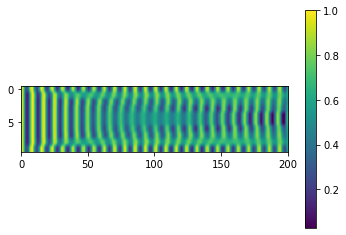

In [18]:
plt.imshow(np.real(obs_ts), aspect=5)
plt.colorbar()

In [46]:
Lx, Ly = 4, 4 # linear dimension of spin 1 2d lattice
N_2d = Lx*Ly # number of sites for spin 1
s = np.arange(N_2d)
x = s%Lx
y = s//Lx

In [47]:
x

array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3], dtype=int32)

In [48]:
y

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3], dtype=int32)

In [50]:
P_y = (Lx-x-1) + Lx*y
P_y

array([ 3,  2,  1,  0,  7,  6,  5,  4, 11, 10,  9,  8, 15, 14, 13, 12],
      dtype=int32)

In [66]:
P_y

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

In [77]:
L = 10 # system size
omega = 2
V0 = 0.5
d = 3.0
Deltas = [[-d/2,i] for i in range(L)]
Omegas = [[omega/2,i] for i in range(L)]
V1 = [[V0/4,i,i+1] for i in range(L-1)]
V2 = [[V0/(4*(2**6)),i,i+2] for i in range(L-2)]
V3 = [[V0/(4*(3**6)),i,i+3] for i in range(L-3)]


static_spin =[["zz",V1],["zI",V1],["Iz",V1],["II",V1],
              ["zz",V2],["zI",V2],["Iz",V2],["II",V2],
              ["zz",V3],["zI",V3],["Iz",V3],["II",V3],
           ["x",Omegas],
          ["z",Deltas],["I",Deltas]] # static part of H

dynamic_spin=[] # time-dependent part of H

s = np.arange(L)
x = s
P_y = (L-x-1) # reflection about y-axis

basis_spin = spin_basis_general(N=L, pyblock=[P_y,0], pauli=-1)

H_spin=hamiltonian(static_spin,dynamic_spin,basis=basis_spin,dtype=np.float64, check_symm=False)
# calculate spin energy levels
H, V = H_spin.eigh()

Hermiticity check passed!


In [78]:
# range in time to evolve system
start,stop,num=0.0,50.0,201
t = np.linspace(start,stop,num=num,endpoint=True)
obs_ts = []
for i in range(L):
    print(i)
    Sz_coeff = [[1.0, i]]
    Sz_op = hamiltonian([['z', Sz_coeff]],[], basis=basis_spin, check_herm=False, check_symm=False)

    psi_0 = np.zeros(basis_spin.Ns) # allocate space for state
    psi_0[0] = 1.0 # set MB state to be the given product state

    U = exp_op(H_spin, a=-1j, start=t.min(), stop=t.max(), num=len(t), iterate=True)

    psi_t = U.dot(psi_0)

    t = U.grid # extract time grid stored in U, and defined in exp_op
    obs_t = obs_vs_time(psi_t,t,dict(I=Sz_op))["I"]
    obs_ts.append(obs_t)
obs_ts = np.array(obs_ts)

0
1
2
3
4
5
6
7
8
9


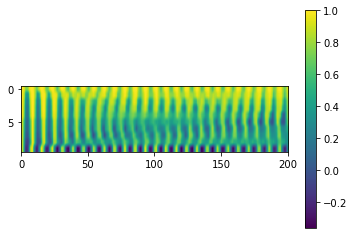

In [79]:
plt.imshow(np.real(obs_ts), aspect=5)
plt.colorbar()

# conformal cooling

In [28]:
def quench(t,t0):
    return np.heaviside(t-t0, 0.0)

def quenchProfile(L,L0,L1,l):
    p = np.zeros(L)
    p[:L0+1] = l
    p[L0:L1+1] = np.linspace(l,0,L1-L0+1)
    p[L1+1:] = 0
    return p

In [29]:
L, L0, L1 = 13, 6, 7
omega = 2
V0 = 24
d = 8.0
t0 = 5
l = 0.9
quench_args=[t0]
start,stop,num=0.0,70.0,401
t = np.linspace(start,stop,num=num,endpoint=True)

Deltas = [[-d/2,i] for i in range(L)]
Omegas = [[omega/2,i] for i in range(L)]
V1 = [[V0/4,i,i+1] for i in range(L-1)]
# V2 = [[V0/(4*(2**6)),i,i+2] for i in range(L-2)]
# V3 = [[V0/(4*(3**6)),i,i+3] for i in range(L-3)]
V1q = [[-(V0/4)*quenchProfile(L, L0, L1, l)[i],i,i+1] for i in range(L-1)]


static_spin = [["x",Omegas],["zz",V1],["zI",V1],["Iz",V1],["II",V1],
          ["z",Deltas],["I",Deltas]] # static part of H

dynamic_spin = [["zz",V1q,quench,quench_args],["zI",V1q,quench,quench_args],["Iz",V1q,quench,quench_args],["II",V1q,quench,quench_args]] # time-dependent part of H

basis_spin = spin_basis_1d(L=L,pauli=-1)

H_i = hamiltonian(static_spin,[],basis=basis_spin,dtype=np.float64, check_symm=False)
H = hamiltonian(static_spin,dynamic_spin,basis=basis_spin,dtype=np.float64, check_symm=False)
# calculate spin energy levels
Ei, Vi = H_i.eigh()
Ei -= Ei[0]

Hermiticity check passed!
Hermiticity check passed!


In [30]:
# psi_i = Vi[:,5]
ni = 4
psi_i = np.sum([Vi[:,i] for i in range(ni)], axis=0)/np.sqrt(ni)

In [31]:
obs_ts = []
psi_t = H.evolve(psi_i,0,t,iterate=False,rtol=1E-9,atol=1E-9)
for i in range(L):
    # print(i)
    Sz_coeff = [[1.0, i]]
    Sz_op = hamiltonian([['z', Sz_coeff]],[], basis=basis_spin, check_herm=False, check_symm=False)
    obs_t = obs_vs_time(psi_t,t,dict(I=Sz_op))["I"]
    obs_ts.append(obs_t)
obs_ts = np.array(obs_ts)

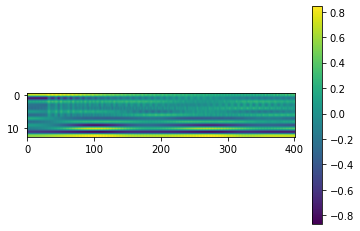

In [32]:
plt.imshow(np.real(obs_ts), aspect=5)
plt.colorbar()

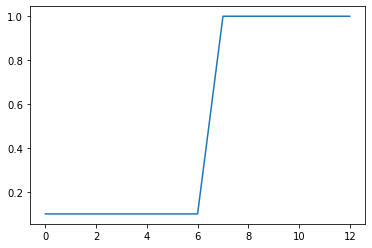

In [33]:
N = 13
n = np.arange(N)
plt.plot(n, 1-quench(t0+1,t0)*quenchProfile(N, L0, L1, l))

## energy density

In [554]:
DeltasSystem = [[-d/2,i] for i in range(L1,L)]
OmegasSystem = [[omega/2,i] for i in range(L1,L)]
V1System = [[(V0/4),i,i+1] for i in range(L1,L-1)]
V1qSystem = [[(V0/4)*quenchProfileStatic(L, L0, L1, 1-l)[i],i,i+1] for i in range(L1,L-1)]
static_spin_system_i = [["x",Omegas],["zz",V1System],["zI",V1System],["Iz",V1System],["II",V1System],["z",Deltas],["I",Deltas]]
static_spin_system_q = [["x",Omegas],["zz",V1qSystem],["zI",V1qSystem],["Iz",V1qSystem],["II",V1qSystem],["z",Deltas],["I",Deltas]]
h_op_i = hamiltonian(static_spin_system_i,[], basis=basis_spin, check_herm=False, check_symm=False)
h_op_q = hamiltonian(static_spin_system_q,[], basis=basis_spin, check_herm=False, check_symm=False)

In [555]:
ti = t[t<=t0]
tq = t[t>=t0]
hexpi = obs_vs_time(psi_t,t,dict(I=h_op_i))
hexpq = obs_vs_time(psi_t,t,dict(I=h_op_q))

Text(0, 0.5, 'norm energy in system')

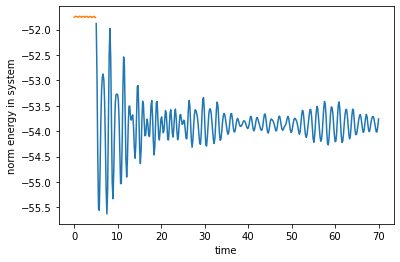

In [558]:
hexpir = np.real(hexpi['I'])
hexpqr = np.real(hexpq['I'])
plt.plot(tq, hexpqr[t>t0])
plt.plot(ti, hexpir[t<=t0])
plt.xlabel("time")
plt.ylabel("norm energy in system")

# quench static

In [90]:
def quench(t,t0):
    return np.heaviside(t-t0, 0.0)

def quenchProfileStatic(L,L0,L1,l):
    p = np.zeros(L)
    p[:L0+1] = l
    p[L0:L1+1] = np.linspace(l,1,L1-L0+1)
    p[L1+1:] = 1
    return p

In [91]:
L, L0, L1 = 11, 6, 7
omega = 2
V0 = 24
d = 1.0
t0 = 1
l = 0.2
quench_args=[t0]
start,stop,num=0.0,50.0,201
t = np.linspace(start,stop,num=num,endpoint=True)

Deltas = [[-d/2,i] for i in range(L)]
Omegas = [[omega/2,i] for i in range(L)]
V1 = [[V0/4,i,i+1] for i in range(L-1)]
# V2 = [[V0/(4*(2**6)),i,i+2] for i in range(L-2)]
# V3 = [[V0/(4*(3**6)),i,i+3] for i in range(L-3)]
V1q = [[(V0/4)*quenchProfileStatic(L, L0, L1, l)[i],i,i+1] for i in range(L-1)]


static_spin0 = [["x",Omegas],["zz",V1],["zI",V1],["Iz",V1],["II",V1],
          ["z",Deltas],["I",Deltas]]

static_spin1 = [["x",Omegas],["zz",V1q],["zI",V1q],["Iz",V1q],["II",V1q],
          ["z",Deltas],["I",Deltas]]

dynamic_spin = [] # time-dependent part of H

basis_spin = spin_basis_1d(L=L,pauli=-1)

H_i = hamiltonian(static_spin0,[],basis=basis_spin,dtype=np.float64, check_symm=False)
H_q = hamiltonian(static_spin1,[],basis=basis_spin,dtype=np.float64, check_symm=False)
# calculate spin energy levels
Ei, Vi = H_i.eigh()
Ei -= Ei[0]

Hermiticity check passed!
Hermiticity check passed!


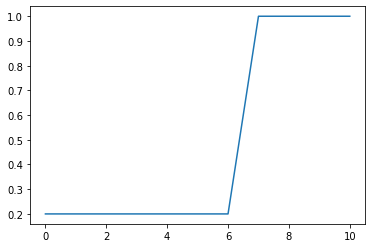

In [92]:
n = np.arange(L)
plt.plot(n, quench(3,2)*quenchProfileStatic(L, L0, L1, l))

In [94]:
psi_i = Vi[:,2]

In [26]:
obs_ts = []
U = exp_op(H_q, a=-1j, start=t.min(), stop=t.max(), num=len(t), iterate=False)
psi_t = U.dot(psi_i)

for i in range(L):
    Sz_coeff = [[1.0, i]]
    Sz_op = hamiltonian([['z', Sz_coeff]],[], basis=basis_spin, check_herm=False, check_symm=False)
    obs_t = obs_vs_time(psi_t,t,dict(I=Sz_op))["I"]
    obs_ts.append(obs_t)
obs_ts = np.array(obs_ts)

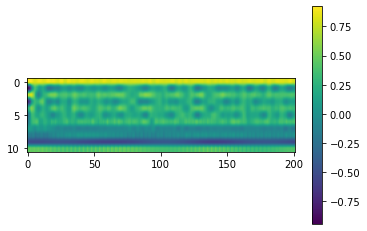

In [27]:
plt.imshow(np.real(obs_ts), aspect=5)
plt.colorbar()

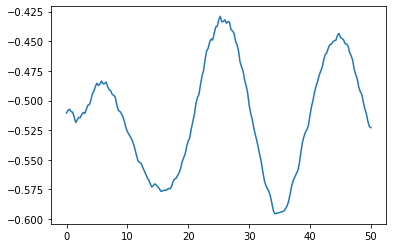

In [21]:
plt.plot(t, np.real(obs_ts[9]))

## energy density

In [22]:
DeltasSystem = [[-d/2,i] for i in range(L1,L)]
OmegasSystem = [[omega/2,i] for i in range(L1,L)]
V1System = [[(V0/4),i,i+1] for i in range(L1,L-1)]
V1qSystem = [[(V0/4)*quenchProfileStatic(L, L0, L1, 1-l)[i],i,i+1] for i in range(L1,L-1)]
static_spin_system_i = [["x",Omegas],["zz",V1System],["zI",V1System],["Iz",V1System],["II",V1System],["z",Deltas],["I",Deltas]]
static_spin_system_q = [["x",Omegas],["zz",V1qSystem],["zI",V1qSystem],["Iz",V1qSystem],["II",V1qSystem],["z",Deltas],["I",Deltas]]
h_op_i = hamiltonian(static_spin_system_i,[], basis=basis_spin, check_herm=False, check_symm=False)
h_op_q = hamiltonian(static_spin_system_q,[], basis=basis_spin, check_herm=False, check_symm=False)

In [23]:
ti = t[t<=t0]
tq = t[t>=t0]
hexpi = obs_vs_time(psi_t,t,dict(I=h_op_i))
hexpq = obs_vs_time(psi_t,t,dict(I=h_op_q))

Text(0, 0.5, 'norm energy in system')

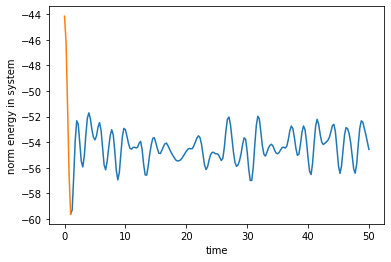

In [24]:
hexpir = np.real(hexpi['I'])
hexpqr = np.real(hexpq['I'])
plt.plot(tq, hexpqr[t>=t0])
plt.plot(ti, hexpir[t<=t0])
plt.xlabel("time")
plt.ylabel("norm energy in system")

# finite temp

In [78]:
def quench(t,t0):
    return np.heaviside(t-t0, 0.0)

def quenchProfileStatic(L,L0,L1,l):
    p = np.zeros(L)
    p[:L0+1] = l
    p[L0:L1+1] = np.linspace(l,1,L1-L0+1)
    p[L1+1:] = 1
    return p

In [92]:
L, L0, L1 = 12, 7, 8
omega = 2
V0 = 24
d = 0.5
t0 = 1
l = 0.2
quench_args=[t0]
start,stop,num=0.0,50.0,201
t = np.linspace(start,stop,num=num,endpoint=True)

Deltas = [[-d/2,i] for i in range(L)]
Omegas = [[omega/2,i] for i in range(L)]
V1 = [[V0/4,i,i+1] for i in range(L-1)]
V2 = [[V0/(4*(2**6)),i,i+2] for i in range(L-2)]
# V3 = [[V0/(4*(3**6)),i,i+3] for i in range(L-3)]
V1q = [[(V0/4)*quenchProfileStatic(L, L0, L1, l)[i],i,i+1] for i in range(L-1)]
V2q = [[(V0/(4*(2**6)))*quenchProfileStatic(L, L0, L1, l)[i],i,i+2] for i in range(L-2)]


static_spin0 = [["x",Omegas],["zz",V1],["zI",V1],["Iz",V1],["II",V1],
                ["zz",V2],["zI",V2],["Iz",V2],["II",V2],
          ["z",Deltas],["I",Deltas]]

static_spin1 = [["x",Omegas],["zz",V1q],["zI",V1q],["Iz",V1q],["II",V1q],
                ["zz",V2q],["zI",V2q],["Iz",V2q],["II",V2q],
          ["z",Deltas],["I",Deltas]]

dynamic_spin = [] # time-dependent part of H

basis_spin = spin_basis_1d(L=L,pauli=-1)

H_i = hamiltonian(static_spin0,[],basis=basis_spin,dtype=np.float64, check_symm=False)
H_q = hamiltonian(static_spin1,[],basis=basis_spin,dtype=np.float64, check_symm=False)
# calculate spin energy levels
Ei, Vi = H_i.eigh()
Ei -= Ei[0]

Hermiticity check passed!
Hermiticity check passed!


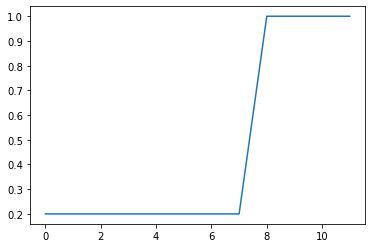

In [93]:
n = np.arange(L)
plt.plot(n, quench(3,2)*quenchProfileStatic(L, L0, L1, l))

In [94]:
hop_ts = []
U = exp_op(H_q, a=-1j, start=t.min(), stop=t.max(), num=len(t), iterate=False)
psi_is = []
nt = 5

for j in range(nt):
    print(j)
    psi_i = Vi[:,j]
    # psi_is.append(psi_i)
    psi_t = U.dot(psi_i)
    hop_ts.append([])
    for i in range(2,L):
        hDelta = [-d/2,i]
        hOmega = [omega/2,i]
        # if (i==0):
        #     hV1q = [0.5*(V0/4)*quenchProfileStatic(L, L0, L1, l)[0],0,1]
        #     static_spin_h = [["x",[hOmega]],["zz",[hV1q]],["zI",[hV1q]],["Iz",[hV1q]],["II",[hV1q]],
        #       ["z",[hDelta]],["I",[hDelta]]]
        # elif (i==L-1):
        #     hV1q = [0.5*(V0/4)*quenchProfileStatic(L, L0, L1, l)[L-1],L-2,L-1]
        #     static_spin_h = [["x",[hOmega]],["zz",[hV1q]],["zI",[hV1q]],["Iz",[hV1q]],["II",[hV1q]],
        #       ["z",[hDelta]],["I",[hDelta]]]
        # else:
        #     hV1qA = [0.5*(V0/4)*quenchProfileStatic(L, L0, L1, l)[i],i-1,i]
        #     hV1qB = [0.5*(V0/4)*quenchProfileStatic(L, L0, L1, l)[i],i,i+1]
        #     static_spin_h = [["x",[hOmega]],["z",[hDelta]],["I",[hDelta]]
        #                      ["zz",[hV1qA]],["zI",[hV1qA]],["Iz",[hV1qA]],["II",[hV1qA]],
        #                      ["zz",[hV1qB]],["zI",[hV1qB]],["Iz",[hV1qB]],["II",[hV1qB]]]
        hV1q = [(V0/4)*quenchProfileStatic(L, L0, L1, l)[0],i-1,i]
        hV2q = [(V0/(4*(2**6)))*quenchProfileStatic(L, L0, L1, l)[i],i-2,i]
        static_spin_h = [["x",[hOmega]],["zz",[hV1q]],["zI",[hV1q]],["Iz",[hV1q]],["II",[hV1q]],
                         ["zz",[hV2q]],["zI",[hV2q]],["Iz",[hV2q]],["II",[hV2q]],
          ["z",[hDelta]],["I",[hDelta]]]
        h_op = hamiltonian(static_spin_h, [], basis=basis_spin, check_herm=False, check_symm=False)
        hop_t = obs_vs_time(psi_t,t,dict(I=h_op))["I"]
        hop_ts[j].append(hop_t)
hop_ts = np.array(hop_ts)

0
1
2
3
4


In [95]:
np.shape(hop_ts)

(5, 10, 201)

In [96]:
beta = 1
print([np.exp(-beta*Ei[i]) for i in range(nt)])
Z = np.sum([np.exp(-beta*Ei[i]) for i in range(nt)])
thermavg = np.real(np.sum([hop_ts[i]*np.exp(-beta*Ei[i])/Z for i in range(nt)], axis=0))

[1.0, 0.34902206134908864, 0.3058162402538051, 0.2596639286468978, 0.21808653554981236]


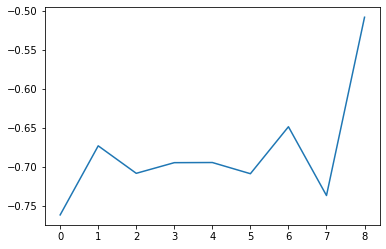

In [97]:
plt.plot(thermavg[:-1,0])

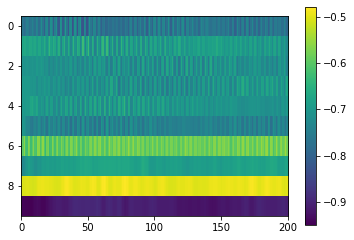

In [98]:
plt.imshow(thermavg, aspect=15, interpolation='nearest')
plt.colorbar()

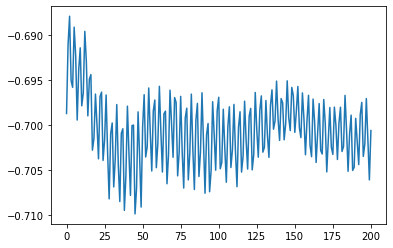

In [99]:
plt.plot(np.mean(thermavg[:L0],axis=0))

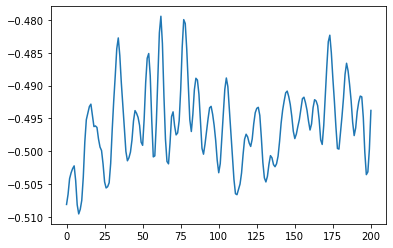

In [100]:
plt.plot(np.mean(thermavg[L1:-1],axis=0))

## Sz

In [88]:
nt = 5
obs_ts = []

for j in range(nt):
    print(j)
    psi_i = Vi[:,j]
    psi_t = U.dot(psi_i)
    obs_ts.append([])
    for i in range(L):
        Sz_coeff = [[1.0, i]]
        Sz_op = hamiltonian([['z', Sz_coeff]],[], basis=basis_spin, check_herm=False, check_symm=False)
        obs_t = obs_vs_time(psi_t,t,dict(I=Sz_op))["I"]
        obs_ts[j].append(obs_t)
obs_ts = np.array(obs_ts)

0
1
2
3
4


In [89]:
beta = 1
print([np.exp(-beta*Ei[i]) for i in range(nt)])
Z = np.sum([np.exp(-beta*Ei[i]) for i in range(nt)])
thermavgSz = np.real(np.sum([obs_ts[i]*np.exp(-beta*Ei[i])/Z for i in range(nt)], axis=0))

[1.0, 0.8863575823694431, 0.7483645631804656, 0.6247252520632661, 0.536098986873004]


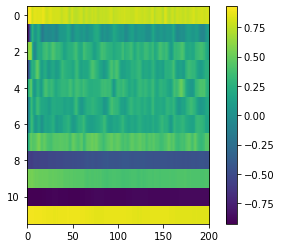

In [90]:
plt.imshow(thermavgSz,aspect=20, interpolation='nearest')
plt.colorbar()

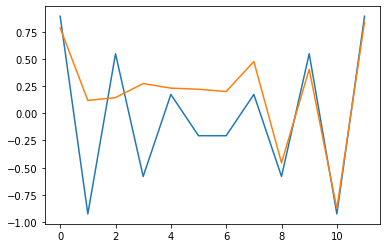

In [91]:
plt.plot(thermavgSz[:,0])
plt.plot(thermavgSz[:,-1])

In [37]:
hop_ts = []
U = exp_op(H_q, a=-1j, start=t.min(), stop=t.max(), num=len(t), iterate=False)
psi_is = []
nt = 10

for j in range(nt):
    print(j)
    psi_i = Vi[:,j]
    # psi_is.append(psi_i)
    psi_t = U.dot(psi_i)
    DeltasSystem = [[-d/2,i] for i in range(L1,L)]
    OmegasSystem = [[omega/2,i] for i in range(L1,L)]
    V1System = [[(V0/4),i,i+1] for i in range(L1,L-1)]
    V1qSystem = [[(V0/4)*quenchProfileStatic(L, L0, L1, 1-l)[i],i,i+1] for i in range(L1,L-1)]
    static_spin_system_q = [["x",Omegas],["zz",V1qSystem],["zI",V1qSystem],["Iz",V1qSystem],["II",V1qSystem],["z",Deltas],["I",Deltas]]
    h_op_q = hamiltonian(static_spin_system_q,[], basis=basis_spin, check_herm=False, check_symm=False)
    hop_t = obs_vs_time(psi_t,t,dict(I=h_op_q))["I"]
    hop_ts.append(hop_t)
hop_ts = np.array(hop_ts)

0
1
2
3
4
5
6
7
8
9


In [38]:
beta = 0.6
print([np.exp(-beta*Ei[i]) for i in range(nt)])
Z = np.sum([np.exp(-beta*Ei[i]) for i in range(nt)])
thermavg = np.real(np.sum([hop_ts[i]*np.exp(-beta*Ei[i])/Z for i in range(nt)], axis=0))

[1.0, 0.44386553393310124, 0.41982907719200324, 0.38813542435243875, 0.3505518914811119, 0.3066709041051098, 0.2590503548642481, 0.22046470660016146, 0.19768110649396958, 0.1895060733378427]


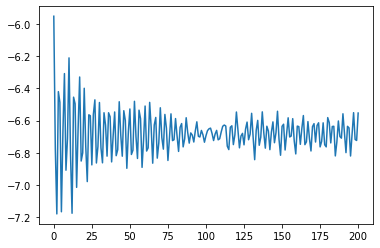

In [39]:
plt.plot(thermavg)

# ramp, no quench

In [13]:
def ramp(t, t0, t1):
    return -np.heaviside(t1-t, 0.0) + (2*(t-t0)/(t1-t0))*np.heaviside(t-t0, 0.0)*np.heaviside(t1-t,0.0) + np.heaviside(t-t1,1.0)

def rampProfile(L,L0,L1,l):
    p = np.zeros(L)
    p[:L0+1] = l
    p[L0:L1+1] = np.linspace(l,1,L1-L0+1)
    p[L1+1:] = 1
    return p

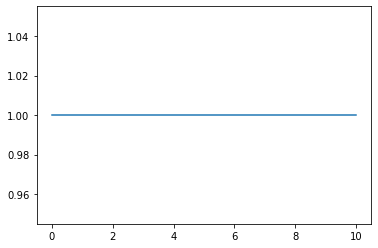

In [113]:
plt.plot(rampProfile(L,L0,L1,1))

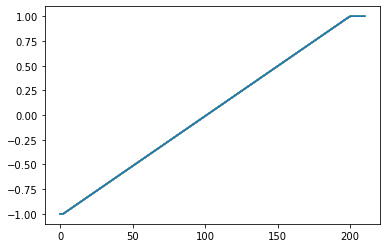

In [49]:
ps = np.outer(rampProfile(L,L0,L1,1), ramp(t, t0, t1))
for p in ps:
    plt.plot(t, p)

In [128]:
L, L0, L1 = 13, 6, 7
omega = 2
V0 = 24
d = 8.0

Deltas_i = [[d/2,i] for i in range(L)]
Deltas = [[-d/2,i] for i in range(L)]
Omegas = [[omega/2,i] for i in range(L)]
V1 = [[V0/4,i,i+1] for i in range(L-1)]
# V2 = [[V0/(4*(2**6)),i,i+2] for i in range(L-2)]
# V3 = [[V0/(4*(3**6)),i,i+3] for i in range(L-3)]

static_spin_i = [["x",Omegas],["zz",V1],["zI",V1],["Iz",V1],["II",V1],["z",Deltas_i],["I",Deltas_i]] # static part of H

basis_spin = spin_basis_1d(L=L,pauli=-1)

H_i = hamiltonian(static_spin_i,[],basis=basis_spin,dtype=np.float64, check_symm=False)

# calculate spin energy levels
Ei, Vi = H_i.eigh()
Ei -= Ei[0]

Hermiticity check passed!


In [130]:
psi_i = Vi[:,0]

In [135]:
t0, t1 = 2, 50
ramp_args=[t0, t1]
start,stop,num=0.0,100.0,201
t = np.linspace(start,stop,num=num,endpoint=True)
dynamic_spin = [["z",Deltas,ramp,ramp_args],["I",Deltas,ramp,ramp_args]] # time-dependent part of H

ls = 1/np.linspace(1,30,7)
Sz_ts = []

for j, l in enumerate(ls):
    print(j, l)
    Sz_ts.append([])
    V1q = [[(V0/4)*rampProfile(L, L0, L1, l)[i],i,i+1] for i in range(L-1)]
    static_spin = [["x",Omegas],["zz",V1q],["zI",V1q],["Iz",V1q],["II",V1q]] # static part of H
    H = hamiltonian(static_spin,dynamic_spin,basis=basis_spin,dtype=np.float64, check_symm=False)
    psi_t = H.evolve(psi_i,0,t,iterate=False,rtol=1E-9,atol=1E-9)
    for i in range(L):
        Sz_coeff = [[1.0, i]]
        Sz_op = hamiltonian([['z', Sz_coeff]],[], basis=basis_spin, check_herm=False, check_symm=False)
        sz_t = obs_vs_time(psi_t,t,dict(I=Sz_op))["I"]
        Sz_ts[j].append(sz_t)

Sz_ts = np.array(Sz_ts)

0 1.0
Hermiticity check passed!
1 0.17142857142857143
Hermiticity check passed!
2 0.09375
Hermiticity check passed!
3 0.06451612903225806
Hermiticity check passed!
4 0.049180327868852465
Hermiticity check passed!
5 0.039735099337748346
Hermiticity check passed!
6 0.03333333333333333
Hermiticity check passed!


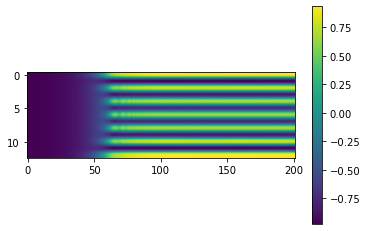

In [139]:
plt.imshow(np.real(Sz_ts[0]), aspect=5)
plt.colorbar()

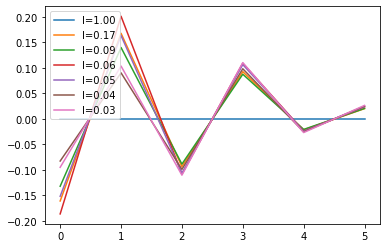

In [142]:
for i in range(len(ls)):
    plt.plot(np.real(Sz_ts)[i,L1:,-1]-np.real(Sz_ts)[0,L1:,-1], label='l={:.2f}'.format(ls[i]))
plt.legend()

# floquet

Hermiticity check passed!
Hermiticity check passed!
Hermiticity check passed!
Hermiticity check passed!


C:\Users\alecj\AppData\Local\Temp\ipykernel_10412\2358055415.py:31: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  H=0.5*hamiltonian(static,dynamic,dtype=np.float64,basis=basis)
C:\Users\alecj\AppData\Local\Temp\ipykernel_10412\2358055415.py:35: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  Heff_0=0.5*hamiltonian(static,[],dtype=np.float64,basis=basis)
C:\Users\alecj\AppData\Local\Temp\ipykernel_10412\2358055415.py:49: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  Heff_2=hamiltonian(Heff_static,[],dtype=np.float64,basis=basis)
C:\Users\alecj\AppData\Local\Temp\ipykernel_10412\2358055415.py:59: UserWarning: Test for symmetries n

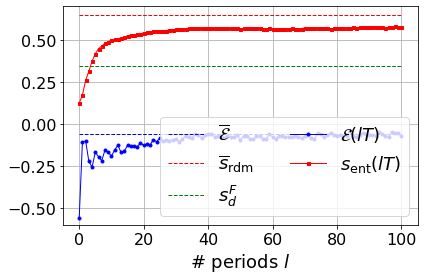

In [132]:
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis
from quspin.tools.measurements import obs_vs_time, diag_ensemble # t_dep measurements
from quspin.tools.Floquet import Floquet, Floquet_t_vec # Floquet Hamiltonian
import numpy as np # generic math functions
#
##### define model parameters #####
L=14 # system size
J=1.0 # spin interaction
g=0.809 # transverse field
h=0.9045 # parallel field
Omega=4.5 # drive frequency
#
##### set up alternating Hamiltonians #####
# define time-reversal symmetric periodic step drive
def drive(t,Omega):
	return np.sign(np.cos(Omega*t))
drive_args=[Omega]
# compute basis in the 0-total momentum and +1-parity sector
basis=spin_basis_1d(L=L,a=1,kblock=0,pblock=1)
# define PBC site-coupling lists for operators
x_field_pos=[[+g,i]	for i in range(L)]
x_field_neg=[[-g,i]	for i in range(L)]
z_field=[[h,i]		for i in range(L)]
J_nn=[[J,i,(i+1)%L] for i in range(L)] # PBC
# static and dynamic lists
static=[["zz",J_nn],["z",z_field],["x",x_field_pos]]
dynamic=[["zz",J_nn,drive,drive_args],
		 ["z",z_field,drive,drive_args],["x",x_field_neg,drive,drive_args]]
# compute Hamiltonians
H=0.5*hamiltonian(static,dynamic,dtype=np.float64,basis=basis)
#
##### set up second-order van Vleck Floquet Hamiltonian #####
# zeroth-order term
Heff_0=0.5*hamiltonian(static,[],dtype=np.float64,basis=basis)
# second-order term: site-coupling lists
Heff2_term_1=[[+J**2*g,i,(i+1)%L,(i+2)%L] for i in range(L)] # PBC
Heff2_term_2=[[+J*g*h, i,(i+1)%L] for i in range(L)] # PBC
Heff2_term_3=[[-J*g**2,i,(i+1)%L] for i in range(L)] # PBC
Heff2_term_4=[[+J**2*g+0.5*h**2*g,i] for i in range(L)]
Heff2_term_5=[[0.5*h*g**2,		  i] for i in range(L)]
# define static list
Heff_static=[["zxz",Heff2_term_1],
			 ["xz",Heff2_term_2],["zx",Heff2_term_2],
			 ["yy",Heff2_term_3],["zz",Heff2_term_2],
			 ["x",Heff2_term_4],
			 ["z",Heff2_term_5]							] 
# compute van Vleck Hamiltonian
Heff_2=hamiltonian(Heff_static,[],dtype=np.float64,basis=basis)
Heff_2*=-np.pi**2/(12.0*Omega**2)
# zeroth + second order van Vleck Floquet Hamiltonian
Heff_02=Heff_0+Heff_2
#
##### set up second-order van Vleck Kick operator #####
Keff2_term_1=[[J*g,i,(i+1)%L] for i in range(L)] # PBC
Keff2_term_2=[[h*g,i] for i in range(L)]
# define static list
Keff_static=[["zy",Keff2_term_1],["yz",Keff2_term_1],["y",Keff2_term_2]]
Keff_02=hamiltonian(Keff_static,[],dtype=np.complex128,basis=basis)
Keff_02*=np.pi**2/(8.0*Omega**2)
#
##### rotate Heff to stroboscopic basis #####
# e^{-1j*Keff_02} Heff_02 e^{+1j*Keff_02}
HF_02 = Heff_02.rotate_by(Keff_02,generator=True,a=1j) 
#
##### define time vector of stroboscopic times with 100 cycles #####
t=Floquet_t_vec(Omega,100,len_T=1) # t.vals=times, t.i=init. time, t.T=drive period
#
##### calculate exact Floquet eigensystem #####
t_list=np.array([0.0,t.T/4.0,3.0*t.T/4.0])+np.finfo(float).eps # times to evaluate H
dt_list=np.array([t.T/4.0,t.T/2.0,t.T/4.0]) # time step durations to apply H for
Floq=Floquet({'H':H,'t_list':t_list,'dt_list':dt_list},VF=True) # call Floquet class
VF=Floq.VF # read off Floquet states
EF=Floq.EF # read off quasienergies
#
##### calculate initial state (GS of HF_02) and its energy
EF_02, psi_i = HF_02.eigsh(k=1,which="SA",maxiter=1E4)
psi_i = psi_i.reshape((-1,))
#
##### time-dependent measurements
# calculate measurements
Sent_args = {"basis":basis,"chain_subsys":[j for j in range(L//2)]}
#meas = obs_vs_time((psi_i,EF,VF),t.vals,{"E_time":HF_02/L},Sent_args=Sent_args)
#"""
# alternative way by solving Schroedinger's eqn
psi_t = H.evolve(psi_i,t.i,t.vals,iterate=True,rtol=1E-9,atol=1E-9)
meas = obs_vs_time(psi_t,t.vals,{"E_time":HF_02/L},Sent_args=Sent_args)
#"""
# read off measurements
Energy_t = meas["E_time"]
Entropy_t = meas["Sent_time"]["Sent"]
#
##### calculate diagonal ensemble measurements
DE_args = {"Obs":HF_02,"Sd_Renyi":True,"Srdm_Renyi":True,"Srdm_args":Sent_args}
DE = diag_ensemble(L,psi_i,EF,VF,**DE_args)
Ed = DE["Obs_pure"]
Sd = DE["Sd_pure"]
Srdm=DE["Srdm_pure"]
#
##### plot results #####
import matplotlib.pyplot as plt
import pylab
# define legend labels
str_E_t = "$\\mathcal{E}(lT)$"
str_Sent_t = "$s_\mathrm{ent}(lT)$"
str_Ed = "$\\overline{\mathcal{E}}$"
str_Srdm = "$\\overline{s}_\mathrm{rdm}$"
str_Sd = "$s_d^F$"
# plot infinite-time data
fig = plt.figure()
plt.plot(t.vals/t.T,Ed*np.ones(t.vals.shape),"b--",linewidth=1,label=str_Ed)
plt.plot(t.vals/t.T,Srdm*np.ones(t.vals.shape),"r--",linewidth=1,label=str_Srdm)
plt.plot(t.vals/t.T,Sd*np.ones(t.vals.shape),"g--",linewidth=1,label=str_Sd)
# plot time-dependent data
plt.plot(t.vals/t.T,Energy_t,"b-o",linewidth=1,label=str_E_t,markersize=3.0)
plt.plot(t.vals/t.T,Entropy_t,"r-s",linewidth=1,label=str_Sent_t,markersize=3.0)
# label axes
plt.xlabel("$\\#\ \\mathrm{periods}\\ l$",fontsize=18)
# set y axis limits
plt.ylim([-0.6,0.7])
# display legend
plt.legend(loc="lower right",ncol=2,fontsize=18)
# update axis font size
plt.tick_params(labelsize=16)
# turn on grid
plt.grid(True)
# save figure
plt.tight_layout()
# plt.savefig('example2.pdf', bbox_inches='tight')
# show plot
plt.show() 

In [ ]:
from numpy.random import default_rng

In [516]:
N = 24*5
rng = default_rng()
vals = np.array((1 - np.abs(0.025*rng.standard_normal(10000)))*(N))
valsr = np.round(vals)

In [521]:
dx = 0.006
h = np.histogram(valsr/N, bins=np.arange(0.9,1.0 + dx/2,dx))
h

(array([   2,    4,   10,    0,   30,   84,  185,    0,  362,  643,    0,
        1144, 1600, 2131,    0, 2518, 1287], dtype=int64),
 array([0.9  , 0.906, 0.912, 0.918, 0.924, 0.93 , 0.936, 0.942, 0.948,
        0.954, 0.96 , 0.966, 0.972, 0.978, 0.984, 0.99 , 0.996, 1.002]))

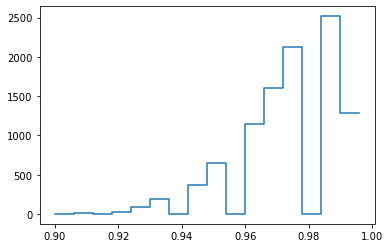

In [522]:
plt.step(h[1][:-1], h[0])

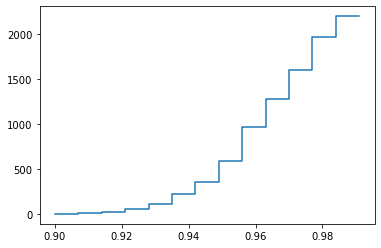

In [523]:
dx = 0.007
hf = np.histogram(vals/N, bins=np.arange(0.9,1.0 + dx/2,dx))
plt.step(hf[1][:-1], hf[0])

In [3]:
import scipy.constants as sc

In [10]:
h = 6.26e-34
f = sc.c/(556e-9)
ep = h*f
P0 = 0.1e-3
rp = P0/ep
dt = 0.1e-6
n = rp*dt
np.sqrt(n)/n

0.00018372155910076877